### Задача 2
Для автоматической сортировки одного из ключевых продуктов предприятия по двум категориям Вам необходимо разработать модель, которая позволит предсказывать категории этого продукта по показаниям датчиков. Вы договорились, что показателем, характеризующим качество Вашей модели, будет AUC. Все необходимые данные лежат по ссылке: https://www.dropbox.com/s/u9mby8wlb9f8xyr/case2.7z?dl=0

### Решение
Этапы решения данной задачи:
1. Разведочный анализ данных и визуализация данных.
2. Предварительная обработка данных - заполнение пропусков.
3. Выбор оптимальной модели машинного обучения.
4. Оптимизация модели - тюнинг гиперпараметров модели.
5. Обучить модель и сделать предсказания на тестовой выборке.

Набор данных представляет собой текстовый файл в формате csv с разделителями с виде запятой (',').

In [1]:
import pandas as pd
import numpy as np
import lightgbm
import xgboost
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from statistics import mean, median
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


#pd.set_option('display.expand_frame_repr', False)
pd.options.display.max_columns = None
warnings.simplefilter(action='ignore', category=FutureWarning)

#### Для ускорения работы можно включить debug mode. В этом режиме используется 10% строк от изначального набора данных.
#### debug = True (включить)
#### debug = False (выключить)

In [2]:
x_train = pd.read_csv('case2/xtrain.csv', sep=',', decimal='.')
y_train = pd.read_csv('case2/ytrain.csv', sep=',', decimal='.')
x_test = pd.read_csv('case2/xtest.csv', sep=',', decimal='.')

debug = False
print('Debug option is: {}'.format(debug))
max_rows_train = len(x_train)
max_rows_test = len(x_test)
if debug == True:
    max_rows_train = int(0.1 * max_rows_train)
    max_rows_test = int(0.1 * max_rows_test)
    x_train = x_train.loc[0:max_rows_train]
    y_train = y_train.loc[0:max_rows_train]
    x_test = x_test.loc[0:max_rows_test]

Debug option is: False


In [3]:
print('Размеры тренировочной выборки данных')
print(x_train.shape)

Размеры тренировочной выборки данных
(900000, 58)


In [4]:
print('Размеры тестовой выборки данных')
print(x_test.shape)

Размеры тестовой выборки данных
(100000, 58)


In [5]:
print('Информация о данных в тренировочной выборке')
print(x_train.describe(include='all'))

Информация о данных в тренировочной выборке
                   1              2              3              4  \
count  820529.000000  808921.000000  831550.000000  828051.000000   
mean       11.012513      12.329729      11.344055      25.406132   
std        99.986889       0.796650       1.662548      20.636810   
min      -480.088690       7.000000       3.000000     -72.310070   
25%       -56.357813      12.000000      10.000000      11.492726   
50%        11.029669      13.000000      11.000000      25.421574   
75%        78.379658      13.000000      13.000000      39.346755   
max       545.896248      13.000000      15.000000     128.900592   

                   5              6              7              8  \
count  819375.000000  796632.000000  791582.000000  796405.000000   
mean        0.313465       2.180648      23.222268     -46.304667   
std         0.536960       0.771303       0.867651      19.875120   
min         0.000000       0.000000      17.000000    -138

In [6]:
print('Информация о данных в тестовой выборке')
print(x_test.describe(include='all'))

Информация о данных в тестовой выборке
                  1             2             3             4             5  \
count  91217.000000  89861.000000  92269.000000  92055.000000  91163.000000   
mean      10.620589     12.330566     11.351245     25.397813      0.310268   
std      100.267392      0.796271      1.661226     20.599782      0.534469   
min     -429.977288      7.000000      4.000000    -63.129935      0.000000   
25%      -57.129449     12.000000     10.000000     11.544007      0.000000   
50%       11.069407     13.000000     11.000000     25.416463      0.000000   
75%       77.911367     13.000000     13.000000     39.269386      1.000000   
max      576.066241     13.000000     15.000000    115.577230      4.000000   

                  6             7             8             9            10  \
count  88514.000000  87962.000000  88437.000000  93306.000000  88268.000000   
mean       2.179915     23.217401    -46.341915      7.895173      0.268931   
std        0

In [7]:
print('Первые несколько строк тренировочного набора данных')
print(x_train.head(5))

Первые несколько строк тренировочного набора данных
           1     2     3          4    5    6     7          8    9   10  \
0 -42.822536   NaN  12.0        NaN  1.0  2.0  24.0 -45.025510  NaN  1.0   
1 -13.478816  13.0  12.0  75.132502  0.0  2.0  24.0 -49.213545  7.0  0.0   
2  51.702721  13.0  12.0  63.459270  0.0  3.0  24.0 -58.777043  8.0  0.0   
3        NaN  12.0  13.0 -15.492561  1.0  1.0  23.0   0.624258  9.0  0.0   
4   7.633273   NaN  13.0  59.862681  0.0  3.0   NaN -61.395319  NaN  0.0   

           11         12          13          14    15         16    17   18  \
0    3.910841  20.037239         NaN  -86.651101  17.0 -11.405955  15.0  4.0   
1  103.028552 -44.603587  -75.457614 -109.772769  16.0  -7.386768  18.0  3.0   
2   14.850524  53.516062  107.018098 -118.540065  17.0 -15.714059  17.0  3.0   
3   60.256580  32.640212   17.508750  -62.551522   NaN  -3.518383  20.0  3.0   
4   62.568909  14.070520   68.503324 -109.179454  17.0 -12.600967  18.0  1.0   

          

In [8]:
print('Первые несколько строк тестового набора данных')
print(x_test.head(5))

Первые несколько строк тестового набора данных
            1     2     3          4    5    6     7          8    9   10  \
0   69.598644  13.0  10.0   7.712229  1.0  0.0  23.0 -46.193433  8.0  0.0   
1  103.612512  13.0  11.0  23.175722  0.0  2.0   NaN -63.054567  8.0  0.0   
2   35.142818  13.0  11.0   3.305209  NaN  2.0   NaN -38.324095  9.0  0.0   
3    3.388459  12.0  13.0  15.083974  1.0  3.0  23.0 -45.735617  6.0  0.0   
4  -67.582684  11.0   NaN  21.282980  0.0  2.0  24.0 -45.644171  8.0  0.0   

           11         12         13          14    15         16    17   18  \
0  103.049872  20.706621  59.673888  -54.090308  18.0  -7.317221  17.0  2.0   
1  -61.106361 -85.240787  81.532641  -67.810005  16.0 -10.608114  17.0  5.0   
2  -12.726749 -46.770119  73.787073         NaN  18.0 -10.532688   NaN  2.0   
3    5.055450 -30.574744  17.703114         NaN  16.0  -7.376130   NaN  NaN   
4   35.684230 -23.442177  48.526249 -119.480172  17.0  -2.527161  17.0  6.0   

          19   

In [9]:
print('Количество наблюдений в тренировочной выборке:', len(x_train))
print('Количество наблюдений в тестовой выборке:', len(x_test))
print('Количество признаков в тренировочной выборке:', len(x_train.columns))
print('Количество признаков в тестовой выборке:', len(x_train.columns))
print('')
print('Количество значений и доли классов в тренировочной выборке')
print('Количество значений класса 0: {}'.format(len(y_train[y_train['x'] == 0])))
print('Доля значений класса 0: {0:.2f}'.format(len(y_train[y_train['x'] == 0]) / len(y_train['x'])))
print('Количество значений класса 1: {}'.format(len(y_train[y_train['x'] == 1])))
print('Доля значений класса 1: {0:.2f}'.format(len(y_train[y_train['x'] == 1]) / len(y_train['x'])))

Количество наблюдений в тренировочной выборке: 900000
Количество наблюдений в тестовой выборке: 100000
Количество признаков в тренировочной выборке: 58
Количество признаков в тестовой выборке: 58

Количество значений и доли классов в тренировочной выборке
Количество значений класса 0: 623940
Доля значений класса 0: 0.69
Количество значений класса 1: 276060
Доля значений класса 1: 0.31


#### Пропуски в данных и их заполнение
##### Тренировочная выборка

In [10]:
print('Пропуски в данных')
print(x_train.isnull().sum())

Пропуски в данных
1      79471
2      91079
3      68450
4      71949
5      80625
6     103368
7     108418
8     103595
9      59956
10    105954
11    107911
12     77918
13     98176
14     77109
15    114703
16     77888
17     95691
18     92278
19     42414
20     70401
21     96029
22     86128
23    131388
24     76619
25     90600
26     76446
27    107409
28     87905
29    113008
30     78357
31     72053
32     79065
33     84265
34     84057
35     99034
36     84897
37     68204
38     83217
39     87747
40    113747
41     67152
42     55306
43     79941
44    105538
45     93753
46     79499
47     86376
48     92006
49     96042
50     63239
51    101394
52     56456
53     85983
54     87182
55     99144
56     87074
57     64634
58    113885
dtype: int64


In [11]:
print('Доля пропусков в данных')
na_sorted = x_train.isnull().sum() / len(x_train)
na_sorted.sort_values(axis=0, ascending=False, inplace=True)
print(na_sorted)

Доля пропусков в данных
23    0.145987
15    0.127448
58    0.126539
40    0.126386
29    0.125564
7     0.120464
11    0.119901
27    0.119343
10    0.117727
44    0.117264
8     0.115106
6     0.114853
51    0.112660
55    0.110160
35    0.110038
13    0.109084
49    0.106713
21    0.106699
17    0.106323
45    0.104170
18    0.102531
48    0.102229
2     0.101199
25    0.100667
28    0.097672
39    0.097497
54    0.096869
56    0.096749
47    0.095973
22    0.095698
53    0.095537
36    0.094330
33    0.093628
34    0.093397
38    0.092463
5     0.089583
43    0.088823
46    0.088332
1     0.088301
32    0.087850
30    0.087063
12    0.086576
16    0.086542
14    0.085677
24    0.085132
26    0.084940
31    0.080059
4     0.079943
20    0.078223
3     0.076056
37    0.075782
41    0.074613
57    0.071816
50    0.070266
9     0.066618
52    0.062729
42    0.061451
19    0.047127
dtype: float64


##### Тестовая выборка

In [12]:
print('Пропуски в данных')
print(x_test.isnull().sum())

Пропуски в данных
1      8783
2     10139
3      7731
4      7945
5      8837
6     11486
7     12038
8     11563
9      6694
10    11732
11    12127
12     8583
13    10905
14     8440
15    12703
16     8694
17    10479
18    10281
19     4659
20     7724
21    10605
22     9554
23    14475
24     8436
25    10143
26     8565
27    11862
28     9801
29    12763
30     8785
31     8006
32     8866
33     9182
34     9258
35    10921
36     9375
37     7664
38     9113
39     9663
40    12493
41     7393
42     6221
43     8989
44    11973
45    10533
46     8756
47     9401
48    10230
49    10498
50     7033
51    11387
52     6272
53     9559
54     9785
55    10905
56     9734
57     7143
58    12684
dtype: int64


In [13]:
na_sorted = x_test.isnull().sum() / len(x_test)
na_sorted.sort_values(axis=0, ascending=False, inplace=True)
print(na_sorted)

23    0.14475
29    0.12763
15    0.12703
58    0.12684
40    0.12493
11    0.12127
7     0.12038
44    0.11973
27    0.11862
10    0.11732
8     0.11563
6     0.11486
51    0.11387
35    0.10921
13    0.10905
55    0.10905
21    0.10605
45    0.10533
49    0.10498
17    0.10479
18    0.10281
48    0.10230
25    0.10143
2     0.10139
28    0.09801
54    0.09785
56    0.09734
39    0.09663
53    0.09559
22    0.09554
47    0.09401
36    0.09375
34    0.09258
33    0.09182
38    0.09113
43    0.08989
32    0.08866
5     0.08837
30    0.08785
1     0.08783
46    0.08756
16    0.08694
12    0.08583
26    0.08565
14    0.08440
24    0.08436
31    0.08006
4     0.07945
3     0.07731
20    0.07724
37    0.07664
41    0.07393
57    0.07143
50    0.07033
9     0.06694
52    0.06272
42    0.06221
19    0.04659
dtype: float64


#### Пропуски в данных заполняем 0.

In [14]:
x_train = x_train.fillna(x_train.mean())
x_test = x_test.fillna(x_test.mean())

#### Визуализация дистрибуции значений признаков
##### Сравним распределение значений признаков в тренировочной и тестовой выборке данных.

In [15]:
sns.set(rc={'figure.figsize':(14,6)})
plt.rcParams.update({'figure.max_open_warning': 0})

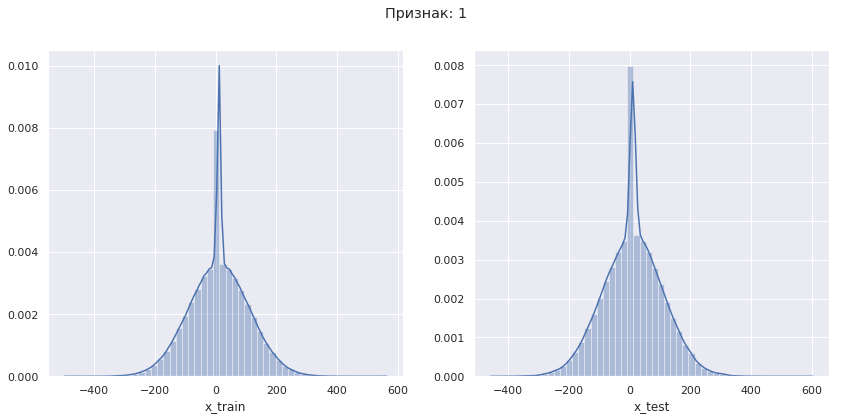

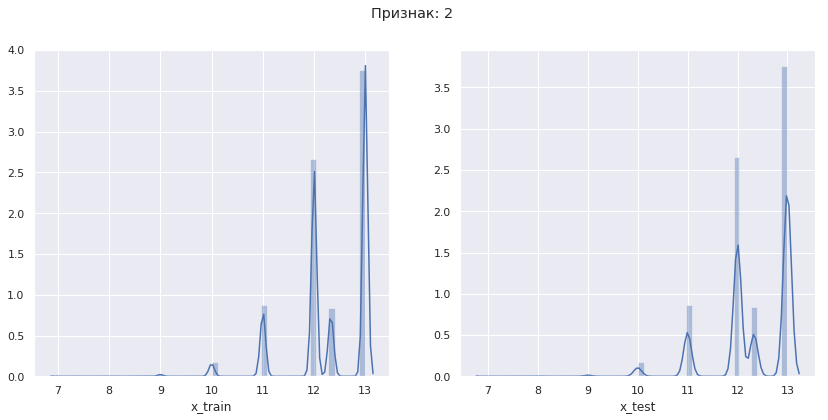

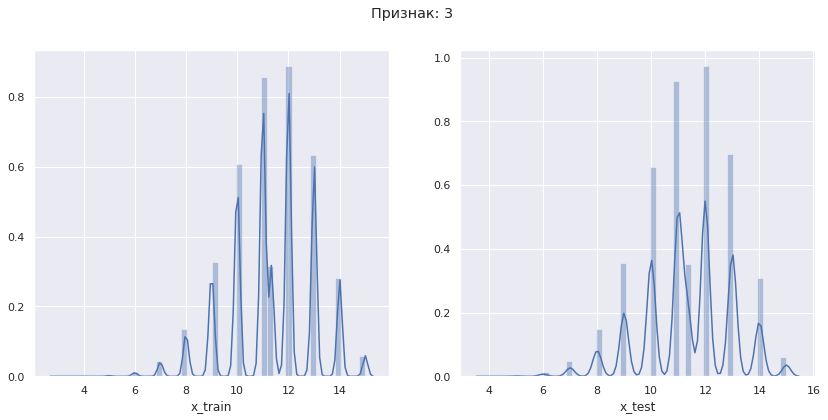

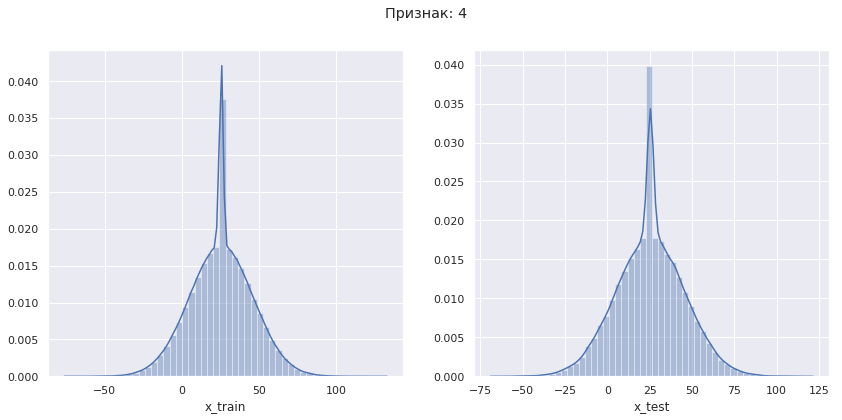

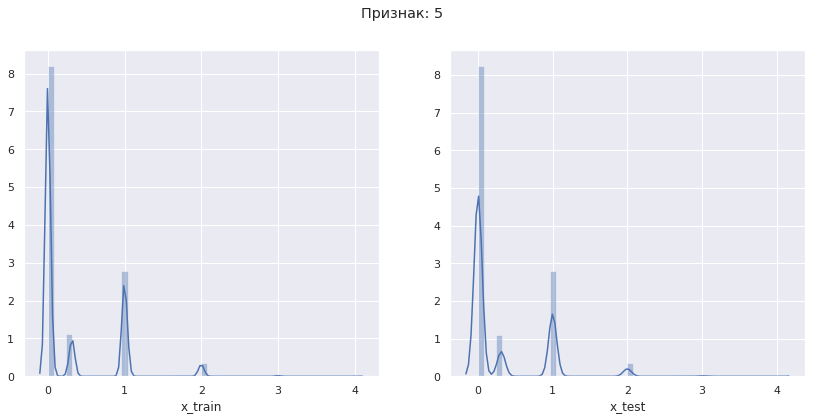

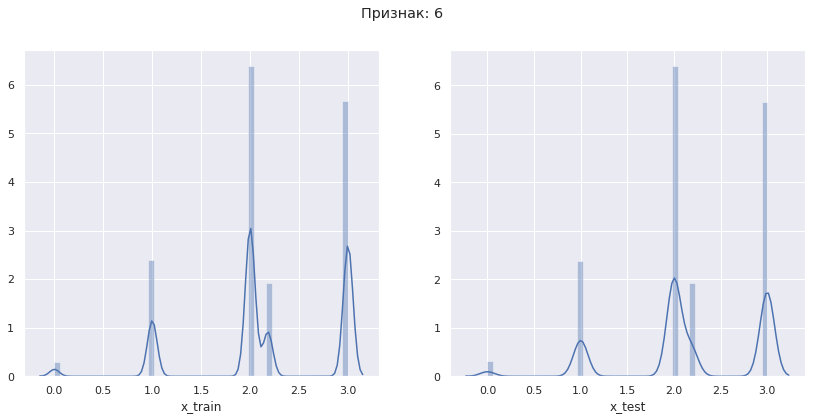

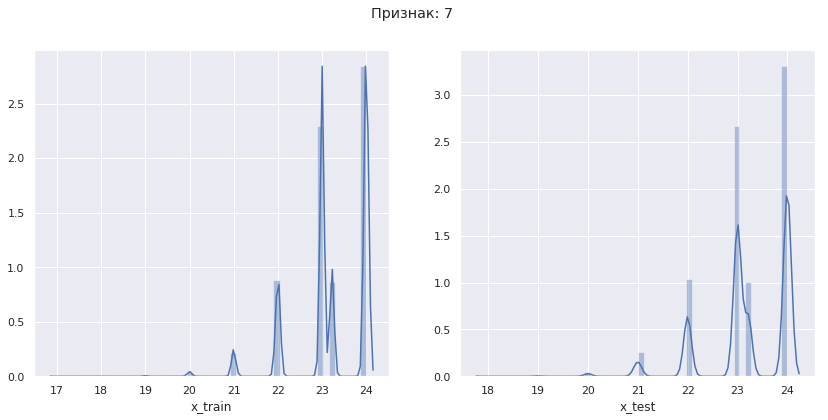

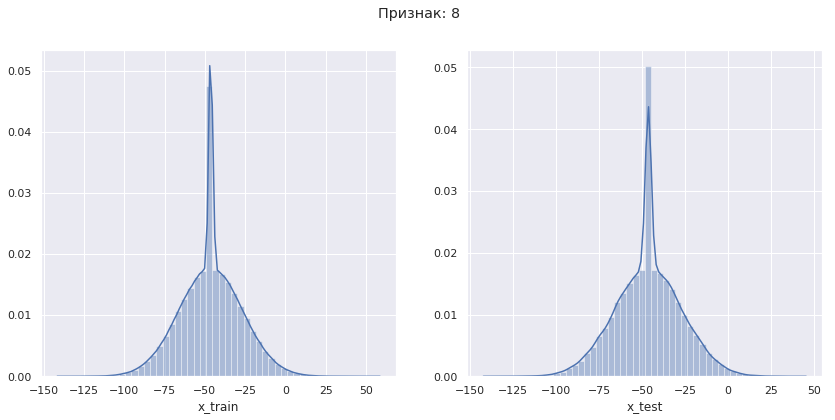

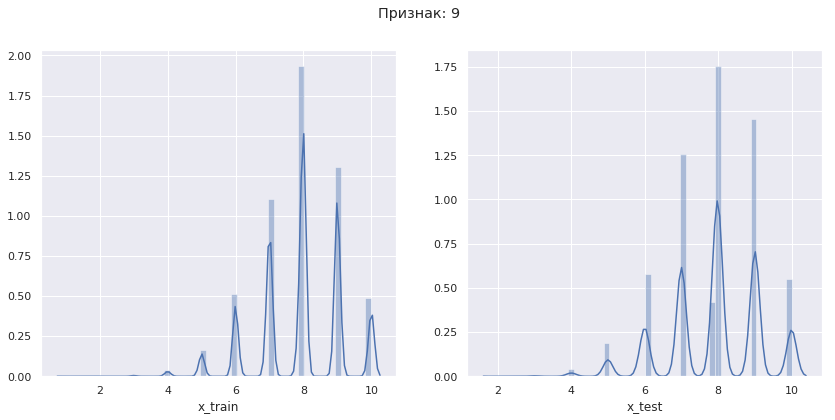

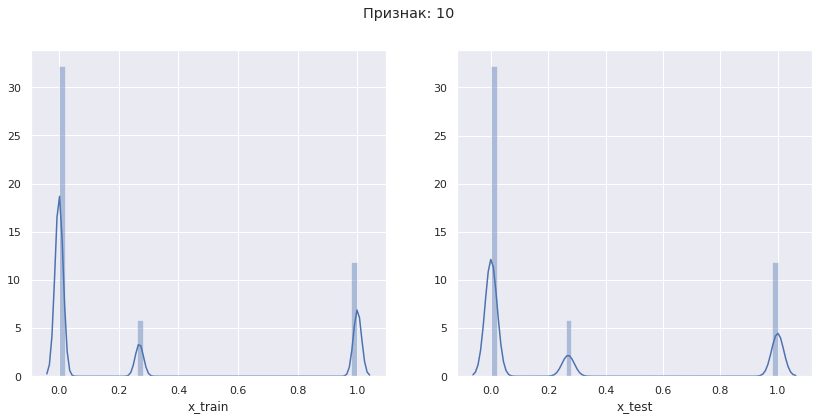

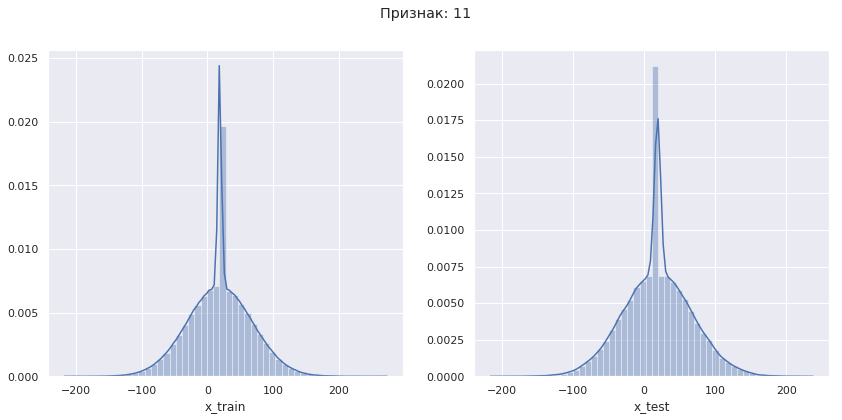

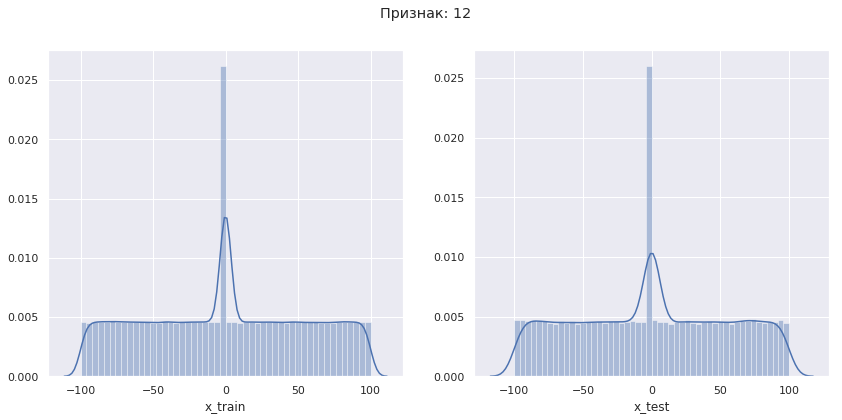

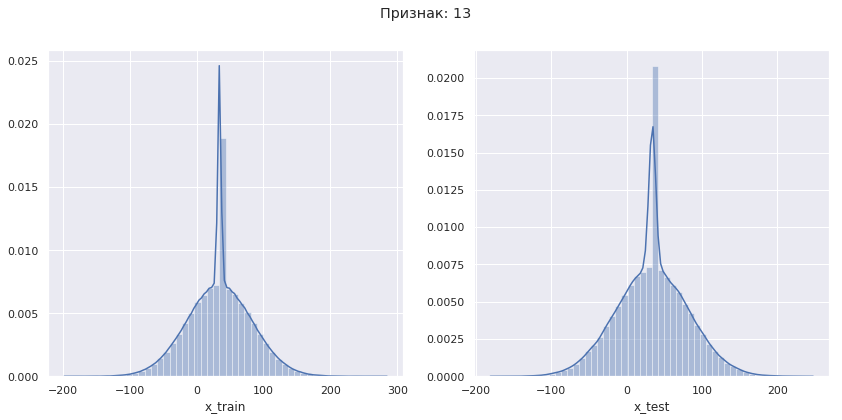

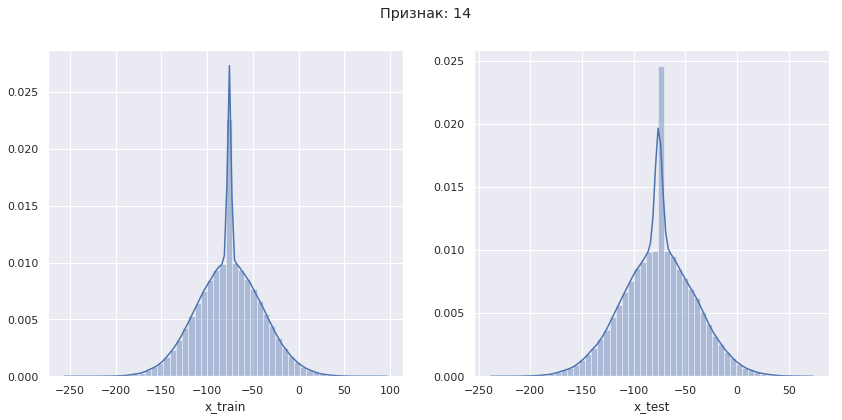

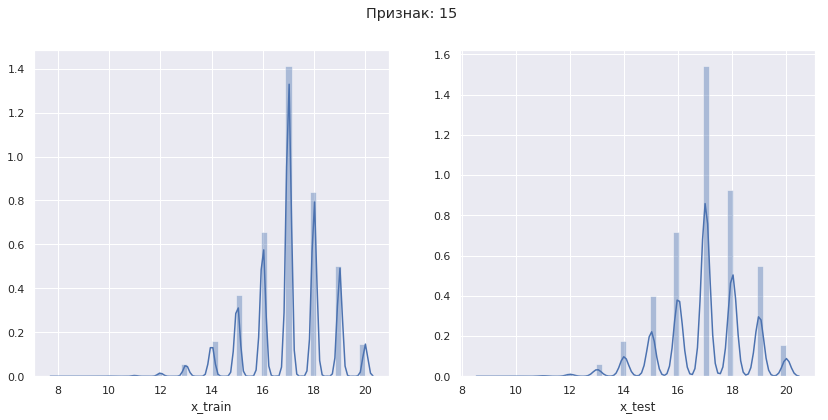

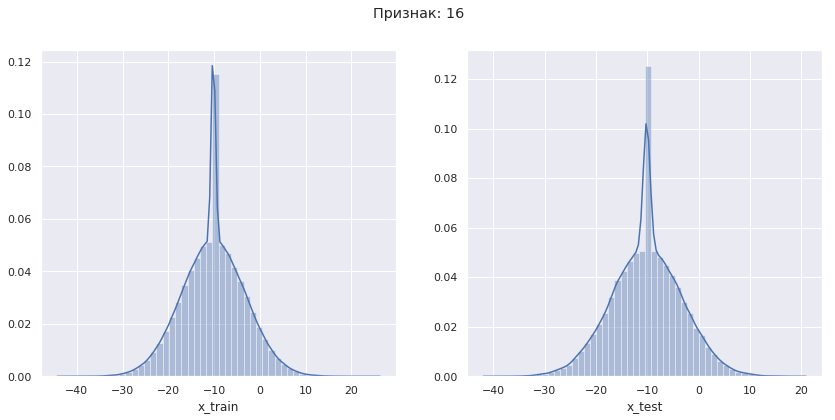

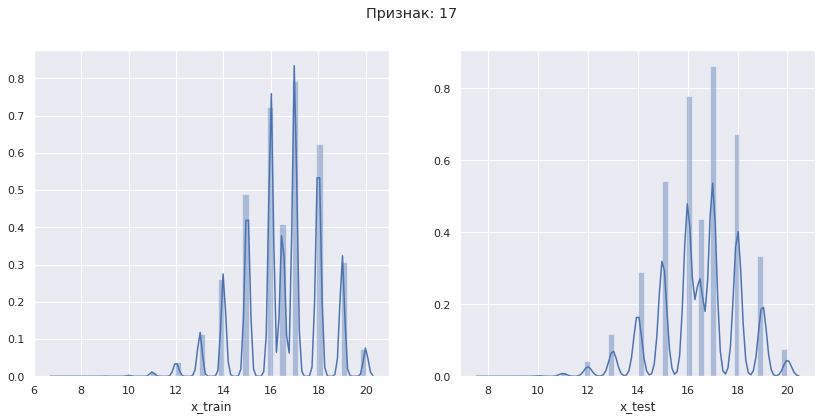

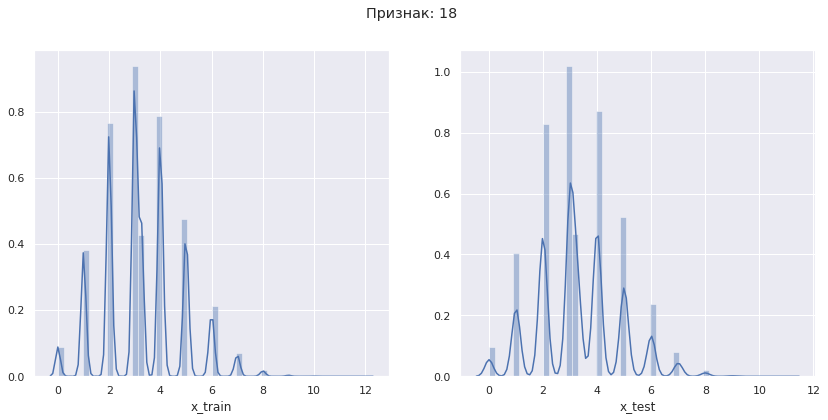

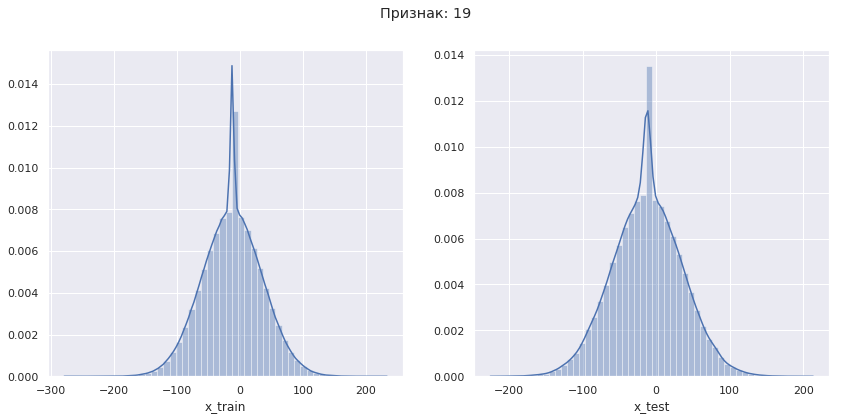

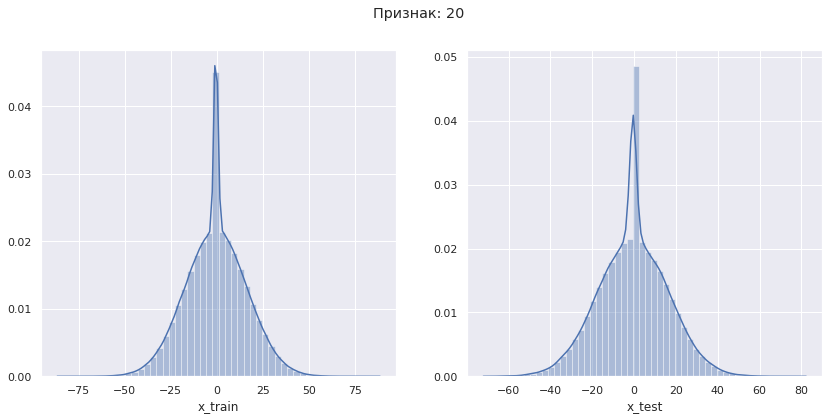

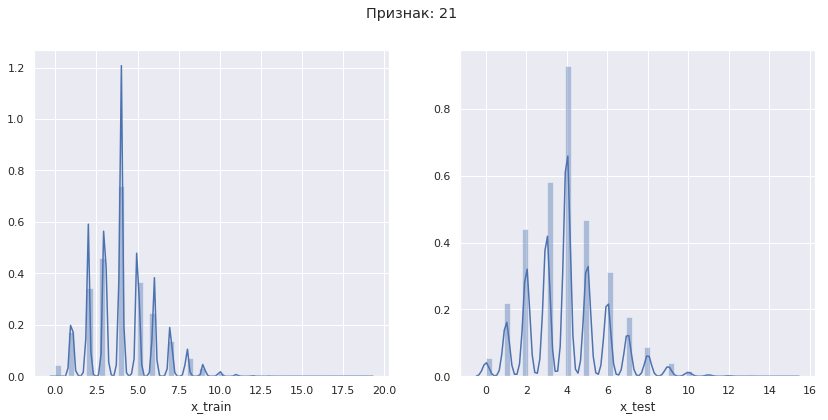

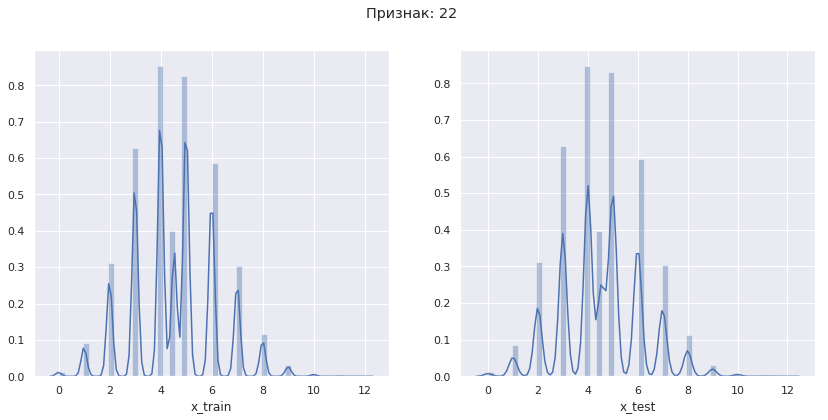

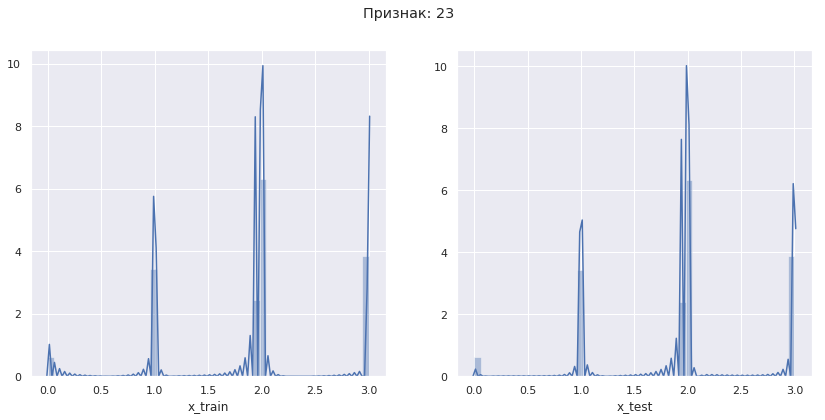

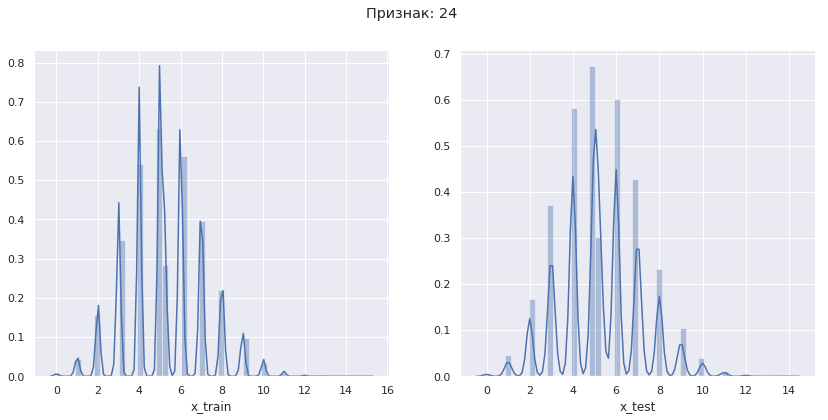

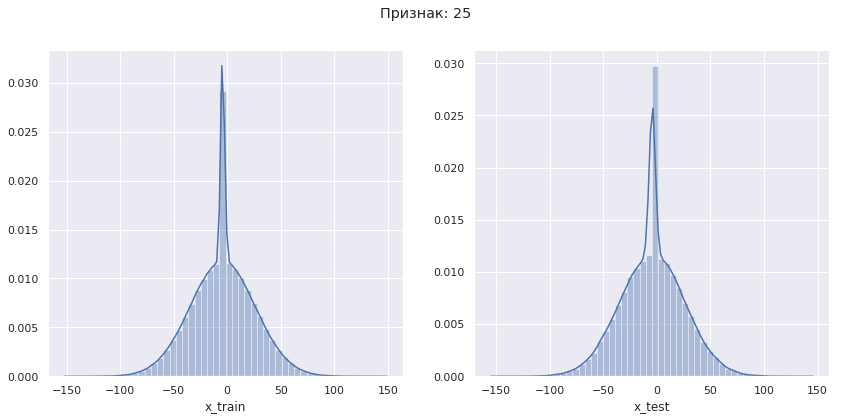

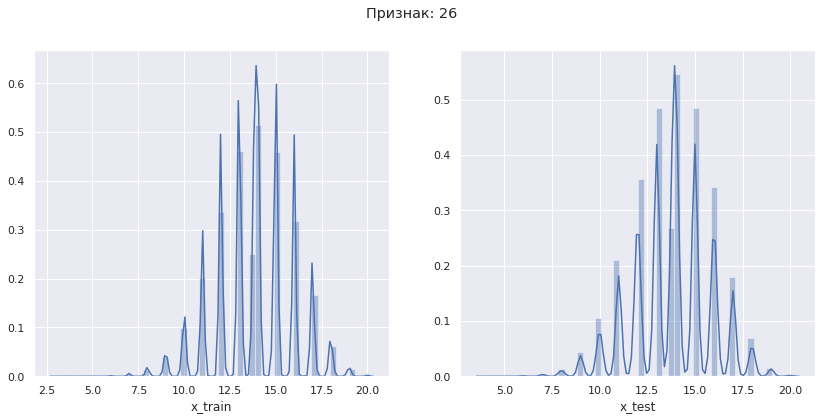

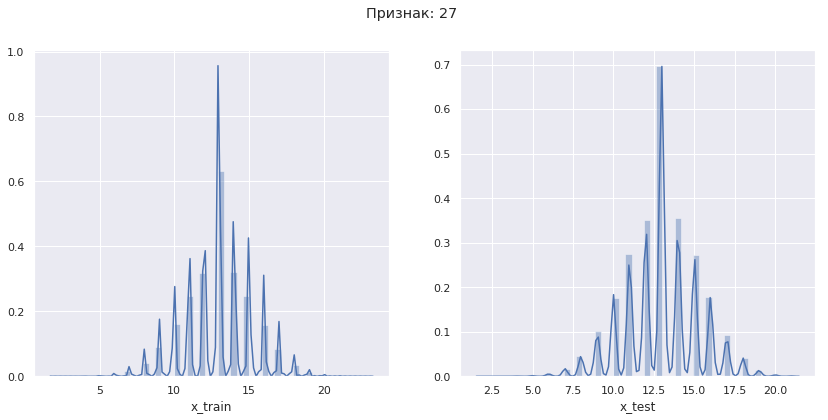

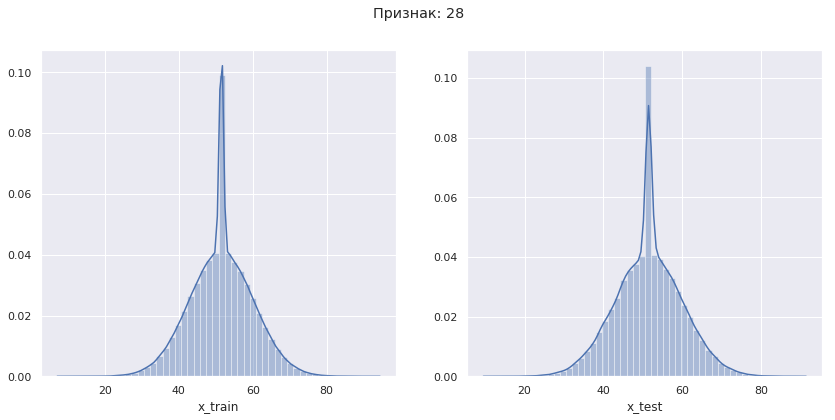

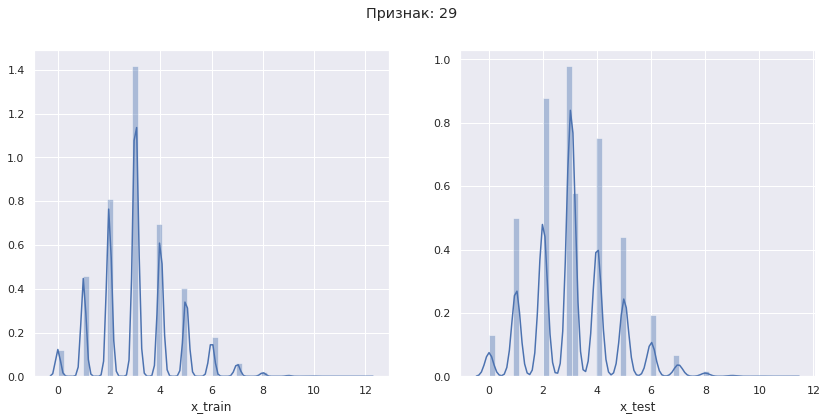

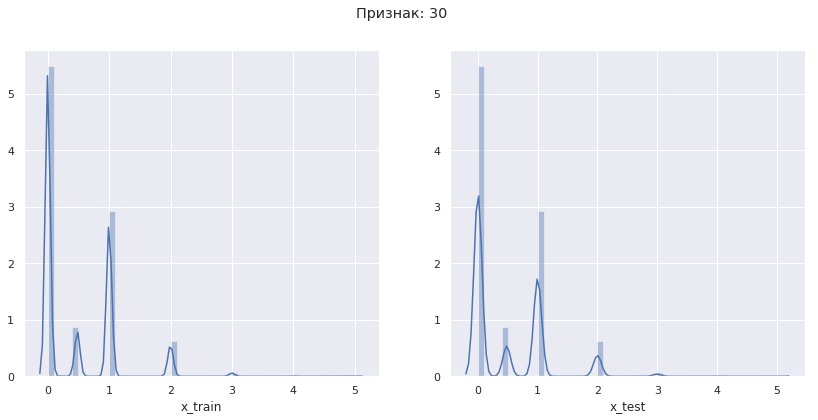

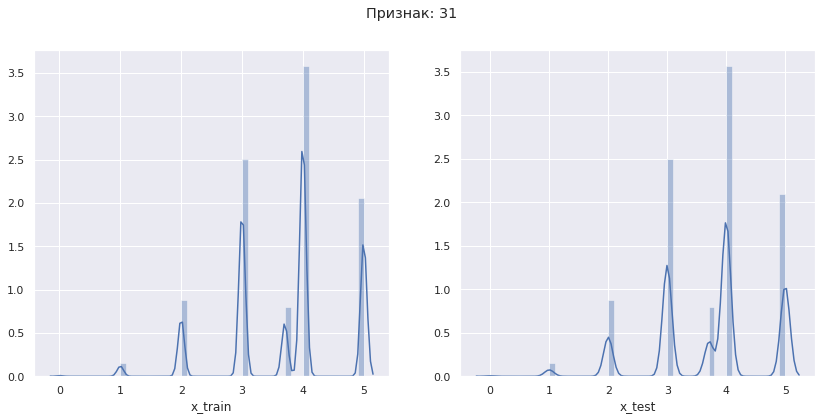

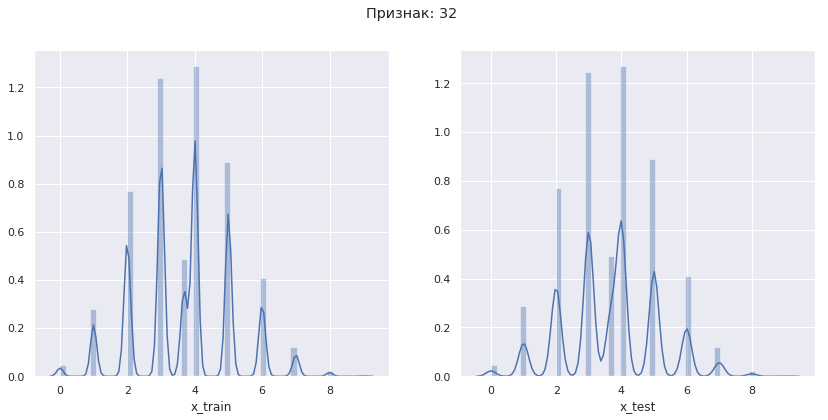

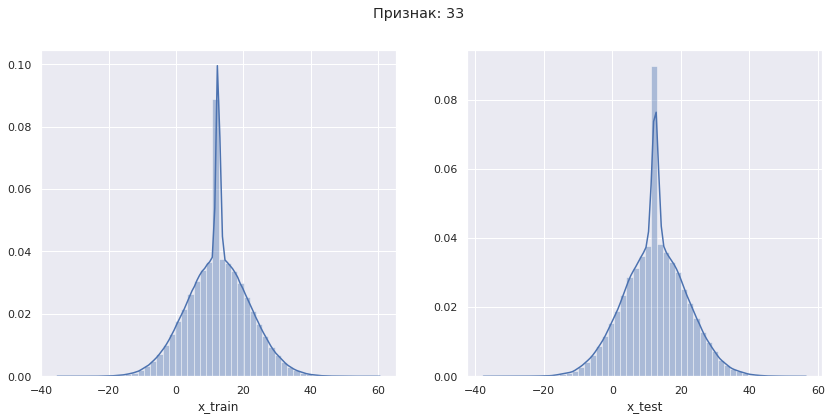

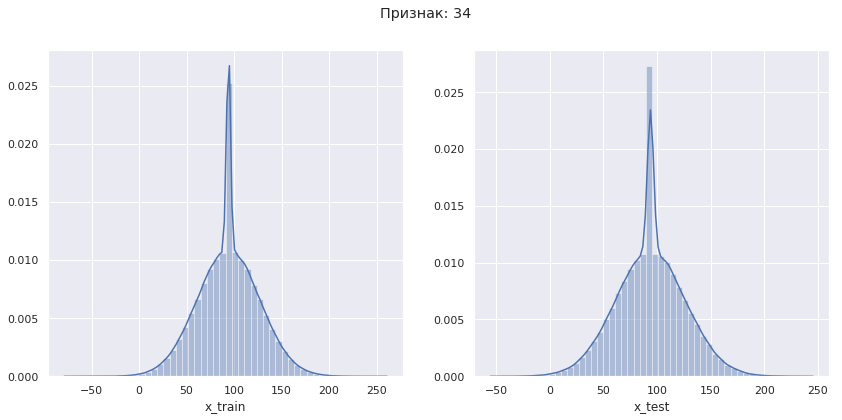

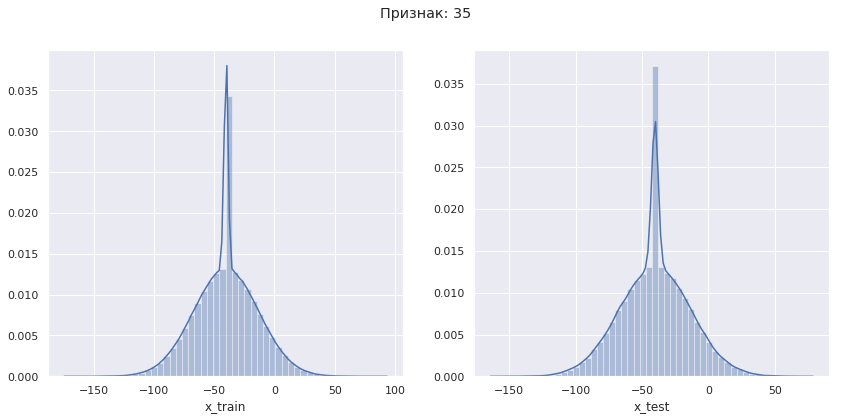

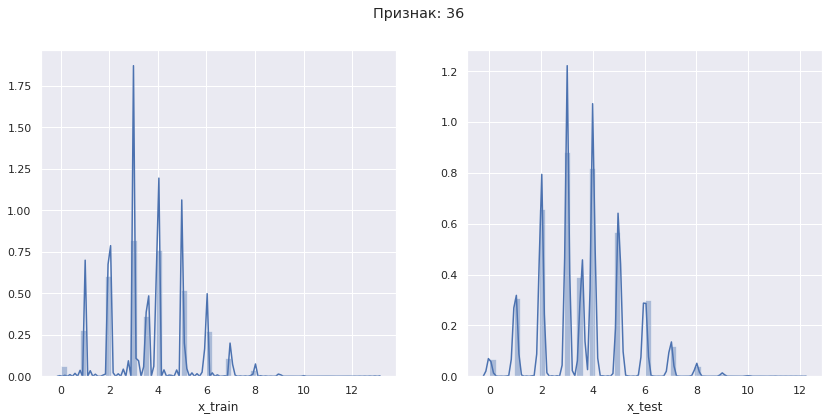

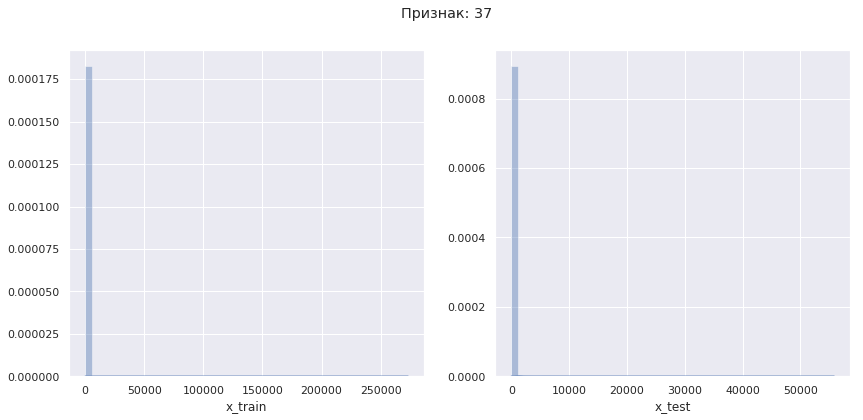

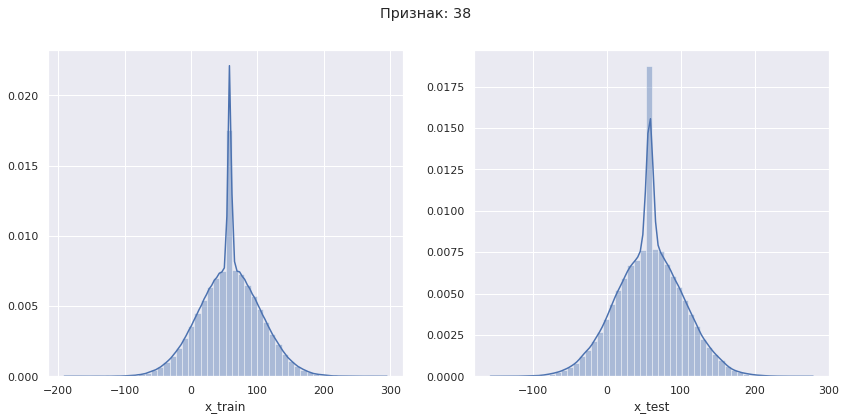

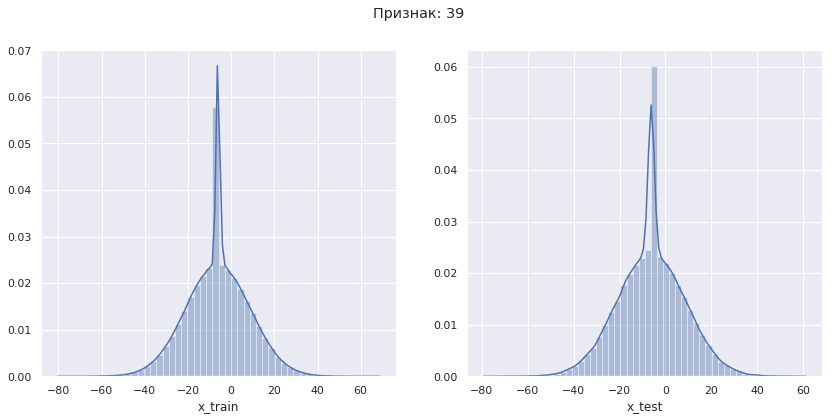

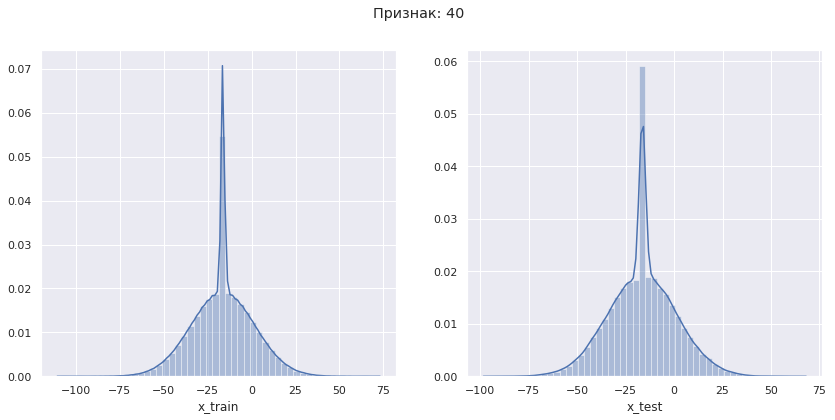

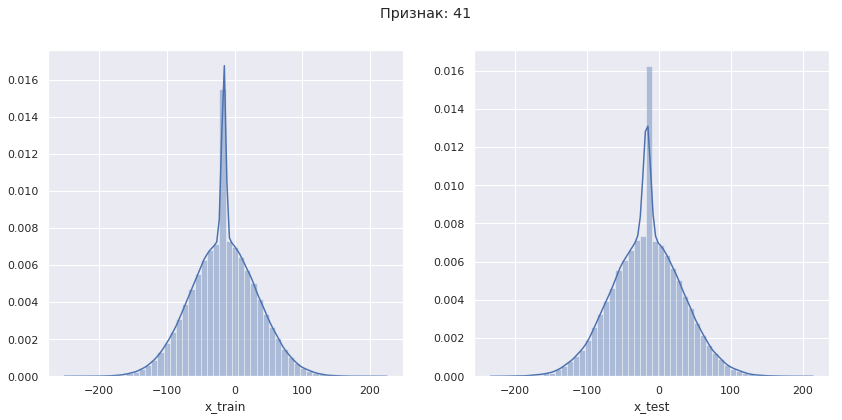

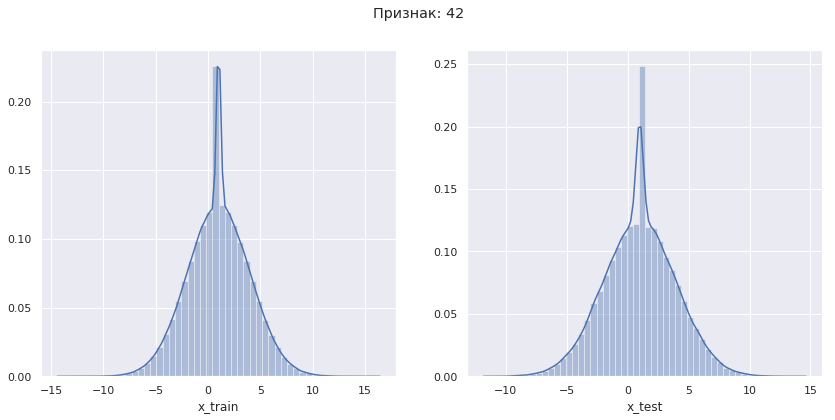

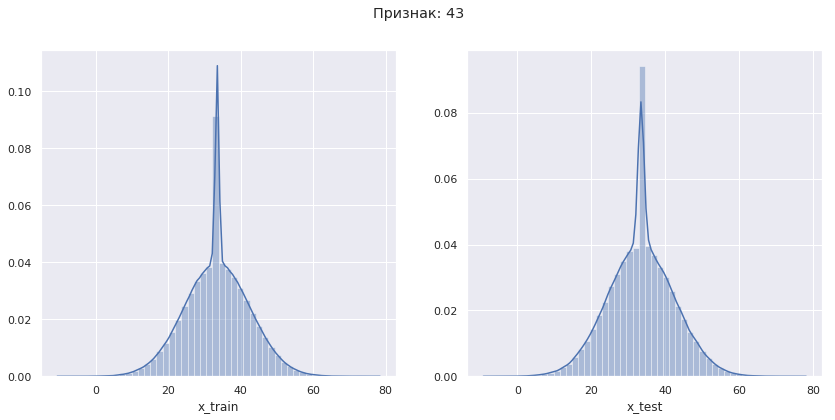

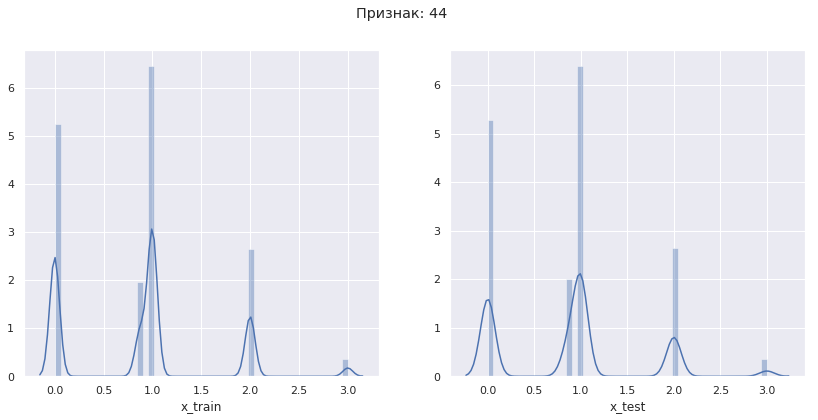

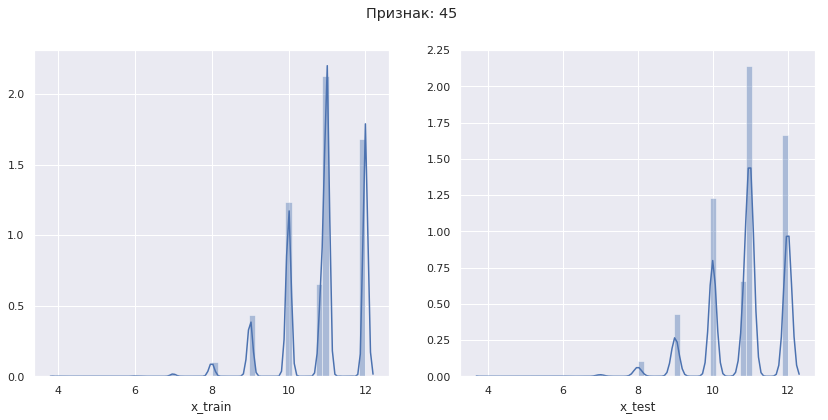

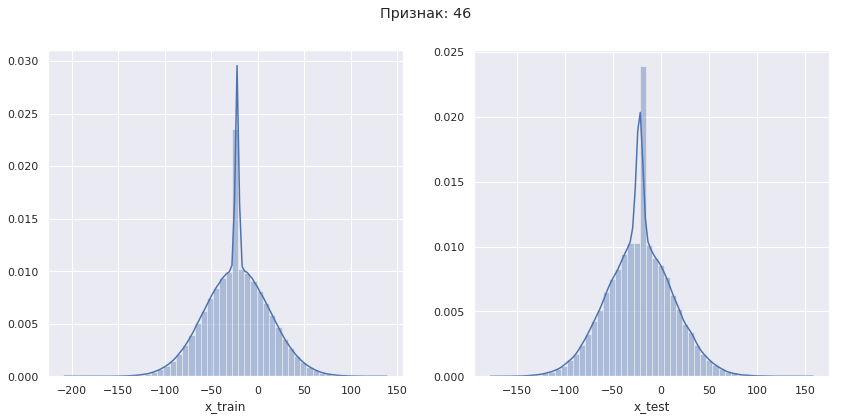

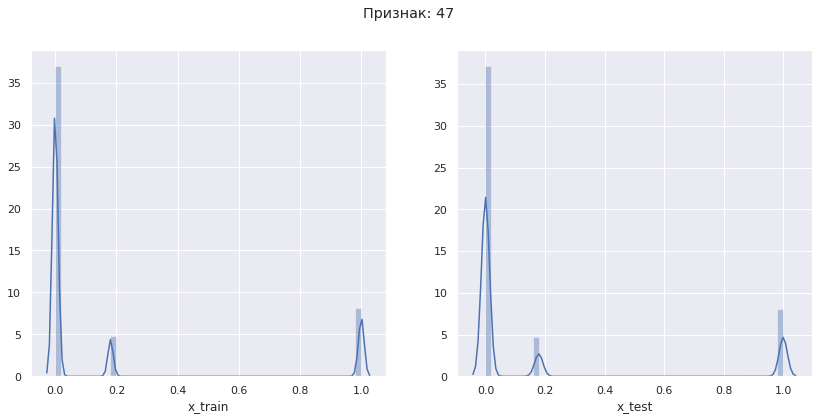

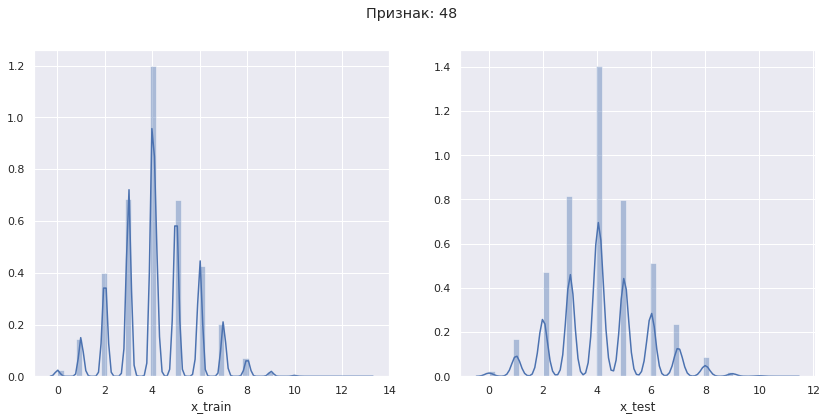

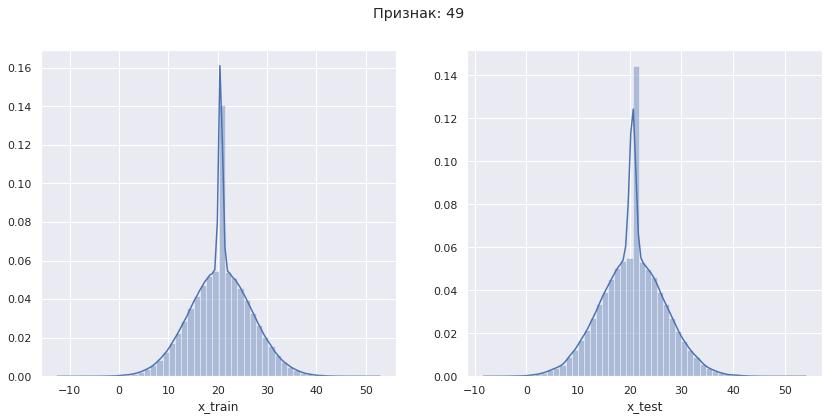

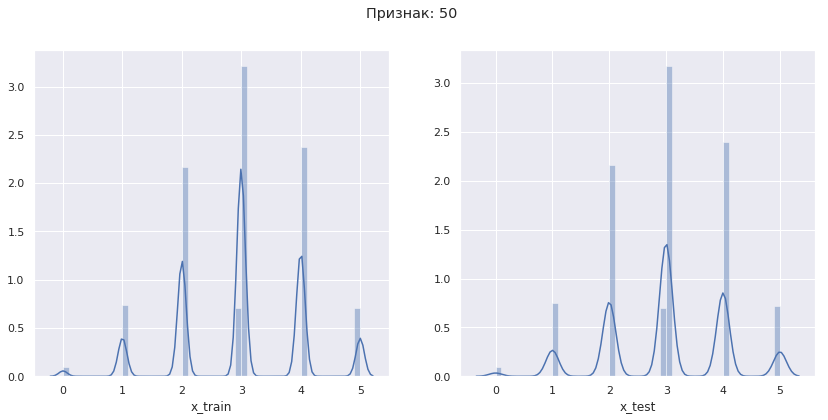

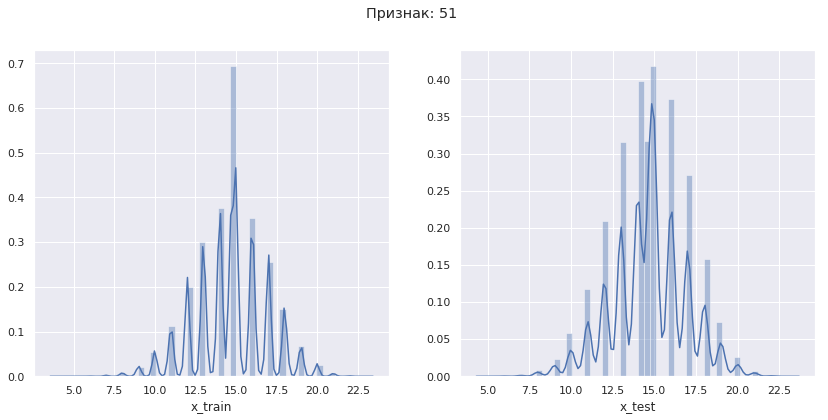

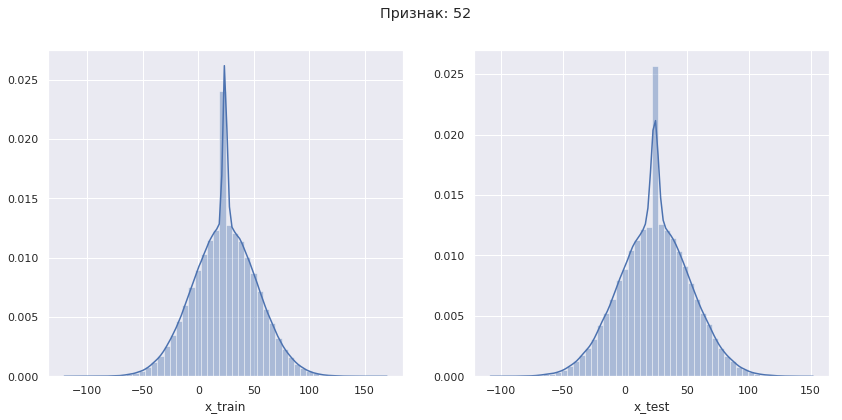

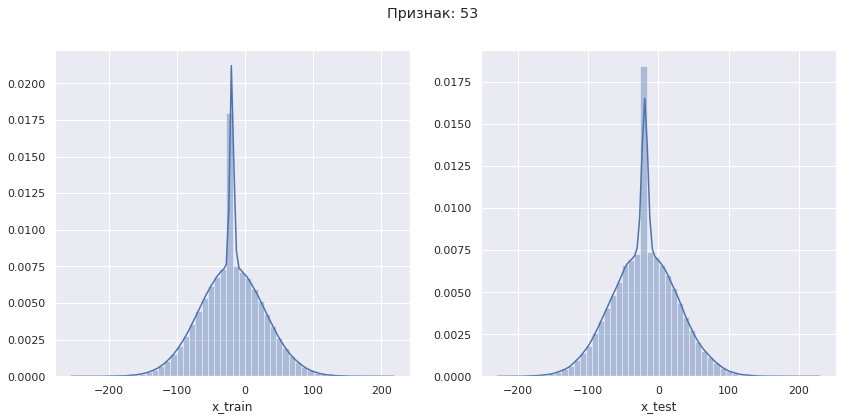

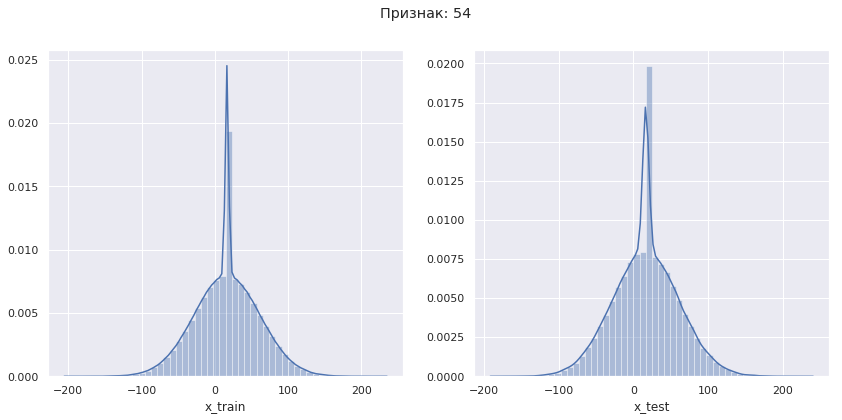

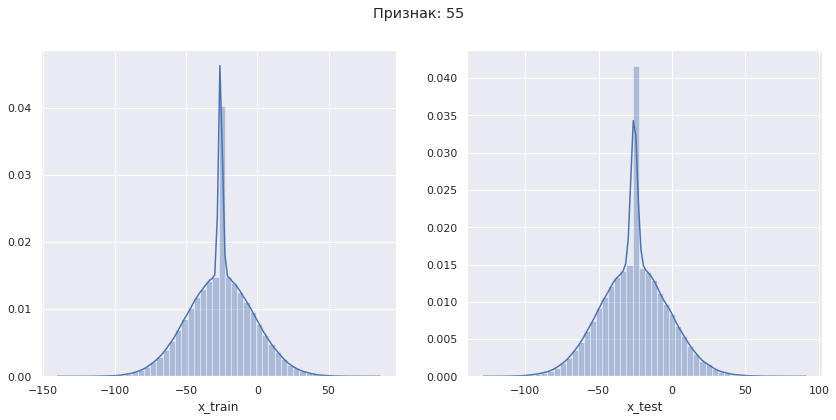

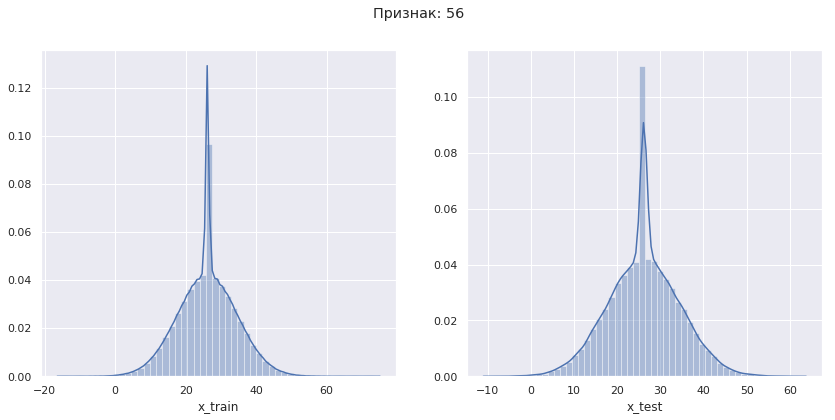

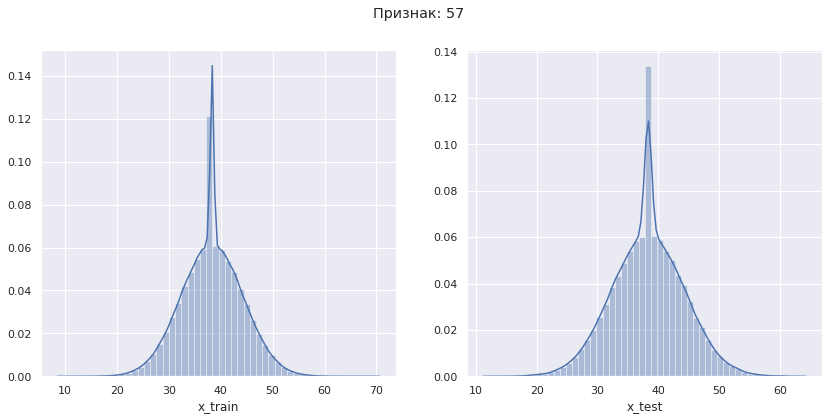

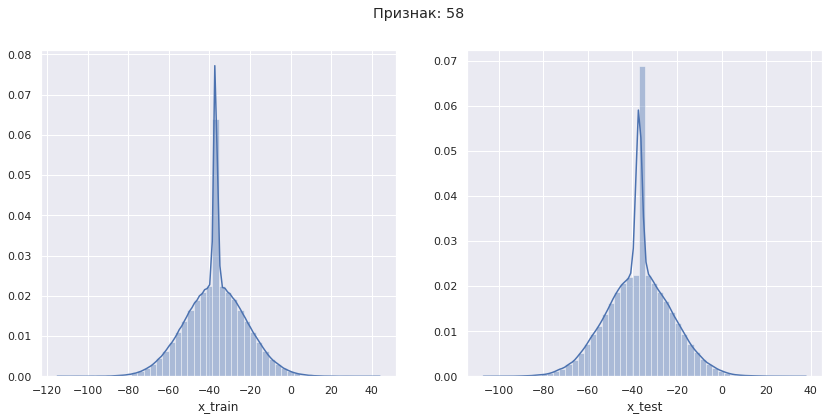

In [16]:
for feature_index in range(58):
    fig, axs = plt.subplots(ncols=2)
    title = 'Признак: '+str(feature_index + 1)
    fig.suptitle(title)
    sns.distplot(x_train.iloc[:, feature_index], ax=axs[0], axlabel='x_train')
    sns.distplot(x_test.iloc[:, feature_index], ax=axs[1], axlabel='x_test')
    plt.show()

#### Нормализация данных.
##### Для решения задачи классификации с большим числом наблюдений (900 000 в тренировочной, 100 000 в тестовой) и признаков (58) имеет смысл использовать алгоритмы машинного обучения, основанные на решающих деревьях. Решающие деревья воспроизводят логические схемы, позволяющие получить окончательное решение о классификации объекта с помощью ответов на иерархически организованную систему вопросов.
##### Так как для решения задачи классификации будем использовать алгоритмы машинного обучения, основанные на решающих деревьях, то нормализации данных не требуется.

#### Выбор алгоритма машинного обучения

Протестируем следующие алгоритмы машинного обучения и определим наилучший с помощью выбранной метрики качества.
Согласно условию задачи метрика качества - AUC (площадь под кривой ошибок). Обучение алгоритмов будет осуществляться на меньшей выборке данных (для ускорения).
Обучение модели будет осуществляться по 4 стратифицированным фолдам (т.к. классы не сбалансированы - 0.69 / 0.31). Разбиение на фолды будет выполнено с помощью соответствующей функции из пакета scikit-learn (https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html).

In [17]:
kf = StratifiedKFold(n_splits=4, random_state=42, shuffle=True)

In [18]:
print('Классификатор - Decision Tree')
clf = DecisionTreeClassifier(criterion='gini', 
                             splitter='best', 
                             max_depth=None, 
                             min_samples_split=2, 
                             min_samples_leaf=1, 
                             min_weight_fraction_leaf=0.0, 
                             max_features=None, 
                             random_state=42, 
                             max_leaf_nodes=None, 
                             min_impurity_decrease=0.0, 
                             min_impurity_split=None, 
                             class_weight=None, 
                             presort=False)
auc_score = cross_val_score(clf, X=x_train, y=y_train['x'], scoring='roc_auc', cv=kf)
print("Mean AUC: %f" % mean(auc_score))

Классификатор - Decision Tree
Mean AUC: 0.642152


In [19]:
print('Классификатор - Random Forest')
clf = RandomForestClassifier(n_estimators=100, 
                             criterion='gini', 
                             max_depth=4, 
                             min_samples_split=2, 
                             min_samples_leaf=1, 
                             min_weight_fraction_leaf=0.0, 
                             max_features='auto', 
                             max_leaf_nodes=None, 
                             min_impurity_decrease=0.0, 
                             min_impurity_split=None, 
                             bootstrap=True, 
                             oob_score=False, 
                             n_jobs=4, 
                             random_state=42, 
                             verbose=0, 
                             warm_start=True, 
                             class_weight=None)
                      
auc_score = cross_val_score(clf, X=x_train, y=y_train['x'], scoring='roc_auc', cv=kf)
print("Mean AUC: %f" % mean(auc_score))


Классификатор - Random Forest
Mean AUC: 0.542484


In [20]:
print('Классификатор - XGBoost')
clf = xgboost.XGBClassifier(max_depth=3, 
                            learning_rate=0.1, 
                            n_estimators=100, 
                            silent=True, 
                            objective='binary:logistic', 
                            booster='gbtree', 
                            n_jobs=4, 
                            nthread=None, 
                            gamma=0, 
                            min_child_weight=1, 
                            max_delta_step=0, 
                            subsample=1, 
                            colsample_bytree=1, 
                            colsample_bylevel=1, 
                            reg_alpha=0, 
                            reg_lambda=1, 
                            scale_pos_weight=1, 
                            base_score=0.5, 
                            random_state=42, 
                            seed=0, 
                            missing=None)
auc_score = cross_val_score(clf, X=x_train, y=y_train['x'], scoring='roc_auc', cv=kf)
print("Mean AUC: %f" % mean(auc_score))

Классификатор - XGBoost
Mean AUC: 0.682976


In [21]:
print('Классификатор - LightGBM')
clf = lightgbm.LGBMClassifier(boosting_type='gbdt', 
                              num_leaves=31, 
                              max_depth=-1, 
                              learning_rate=0.1, 
                              n_estimators=100, 
                              subsample_for_bin=200000, 
                              objective='binary', 
                              class_weight=None, 
                              min_split_gain=0.0, 
                              min_child_weight=0.001, 
                              min_child_samples=20, 
                              subsample=1.0, 
                              subsample_freq=0, 
                              colsample_bytree=1.0, 
                              reg_alpha=0.0, 
                              reg_lambda=0.0, 
                              random_state=42, 
                              n_jobs=4, 
                              silent=True, 
                              importance_type='split')
auc_score = cross_val_score(clf, X=x_train, y=y_train['x'], scoring='roc_auc', cv=kf)
print("Mean AUC: %f" % mean(auc_score))

Классификатор - LightGBM
Mean AUC: 0.718420


#### По значению выбранной метрики AUC и скорости работы выбран оптимальный алгоритм - LightGBM.

#### Оптимизация гиперпараметров
##### Для получения лучшего результата необходимо выполнить оптимизацию гиперпараметров алгоритма машинного обучения. Оптимизация будет выполнена с помощью рандомизированного поиска RandomizedSearchCV (https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html ).
##### Сетка гиперпараметров задана в словаре grid_params.

In [22]:
def optimize_hyperparams(clf):
    grid_params = {
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [100, 200, 400],
    'num_leaves': [6, 12, 18, 24, 31]
    }

    random_cv = RandomizedSearchCV(estimator=clf,
                                   param_distributions=grid_params,
                                   cv=kf,
                                   n_iter=8,
                                   scoring='roc_auc',
                                   n_jobs=4,
                                   return_train_score=True,
                                   random_state=42)

    random_cv.fit(X=x_train, y=y_train['x'])

    print('Лучшие параметры:')
    print(random_cv.best_params_)
    print('Лучшая оценка:')
    print(random_cv.best_score_)
    return random_cv.best_params_

Лучшие параметры:
{'num_leaves': 18, 'n_estimators': 400, 'learning_rate': 0.1}

#### Применение оптимальных гиперпараметров к модели и проверка качества модели. 

In [23]:
clf = lightgbm.LGBMClassifier(boosting_type='gbdt',
                              num_leaves=18,
                              max_depth=6,
                              learning_rate=0.1,
                              n_estimators=400,
                              subsample_for_bin=200000,
                              objective='binary',
                              class_weight=None,
                              min_split_gain=0.0,
                              min_child_weight=0.001,
                              min_child_samples=20,
                              subsample=1.0,
                              subsample_freq=0,
                              colsample_bytree=1.0,
                              reg_alpha=0.0,
                              reg_lambda=0.0,
                              random_state=42,
                              n_jobs=4,
                              silent=True,
                              importance_type='split')
auc_score = cross_val_score(clf, X=x_train, y=y_train['x'], scoring='roc_auc', cv=kf)
print("Mean AUC: %f" % mean(auc_score))
clf.fit(X=x_train, y=y_train['x'])

Mean AUC: 0.725552


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=6,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=400, n_jobs=4, num_leaves=18, objective='binary',
        random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

#### Важность признаков

In [24]:
def plot_feature_importance(model, X_train):
    feature_importance = model.feature_importances_
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 2)
    plt.barh(pos, feature_importance[sorted_idx], align='center')
    plt.yticks(pos, X_train.columns[sorted_idx])
    plt.xlabel('Относительная важность')
    plt.title('Важность признаков')

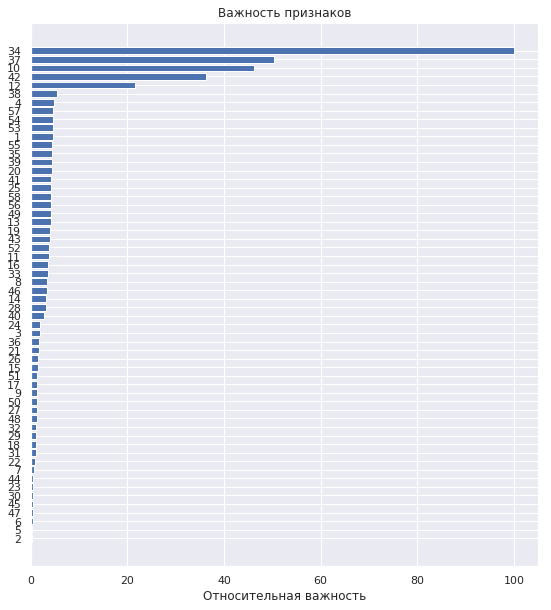

In [25]:
plot_feature_importance(model=clf, X_train=x_train)

In [26]:
y_test = pd.DataFrame(clf.predict_proba(X=x_test))
y_test.to_csv('y_test.csv', index=False)